## Homework 4
1. Implement gradient descent
2. Logistic regression
3. Optimize ${4x_1}^6 + {3x_2}^4$
4. Train perceptron
5. Animate gif with perceptron training 
6. Plot different $\alpha$(learning rate)

Test performance also with quadratic features and on real and synthetic dataset.

In [1]:
%matplotlib inline
# standard library
import itertools

# pandas
import pandas as pd

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for animatin
from matplotlib.animation import FuncAnimation

import sklearn.datasets

# general
from common import (plot_boundaries, one_hot_encode, 
                    generate_dataset, pad_design_matrix)

# html embedding, for video
from IPython.display import HTML


# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

In [2]:
def gradient_descent(theta, grad_func, alpha=0.001, epochs=100):
    """Perform gradeint descent on the given values with a given
    learning rate"""
    yield theta
    for i in range(epochs):
        theta -= alpha * grad_func(theta)  # descend on the gradient
        yield theta

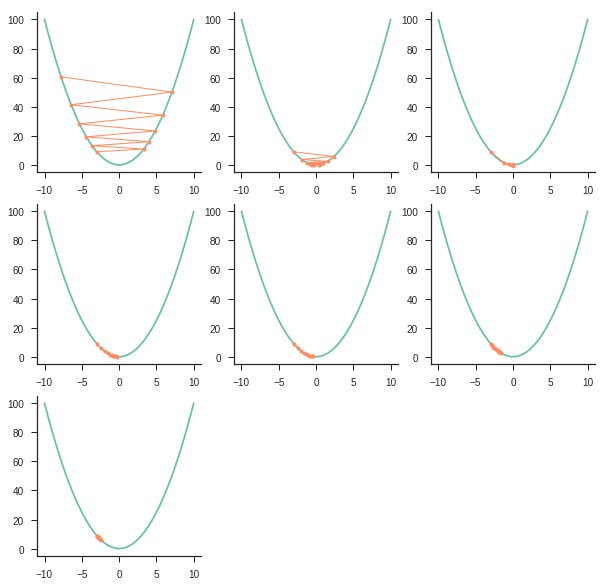

In [3]:
# plot descent
func = lambda x: x**2
grad = lambda x: 2 * x

plt.figure(figsize=(10, 10))

for i, alpha in enumerate([1.05, 0.9, 0.3, 0.1, 0.09, 0.03, 0.01]):
    x_vals = np.array(list(gradient_descent(theta=-3, grad_func=grad, alpha=alpha, epochs=10)))
    y_vals = func(x_vals)

    plt.subplot(3, 3, i+1)
    plt.plot(np.linspace(-10, 10), func(np.linspace(-10, 10)))
    plt.plot(x_vals, y_vals, 'o-', markersize=4, linewidth=1)
    sns.despine()

In [4]:
# logistic regression train with gradient descent
def logistic_regression_grad(X, Y, beta):
    """Returns the gradient of the loss function of logistic
    regression with respect to beta."""
    grads = []
    classes = [X[Y[:, cls] == 1] for cls in range(Y.shape[1])]
    for cls_points, cls_beta in zip(classes, list(beta)):
        losses = []  # all the losses
        for point in cls_points:
            losses.append(point * (1 - np.exp(cls_beta.dot(point.T)) / 
                                       np.exp(beta.dot(point)).sum()))
            
        grads.append(-sum(losses))  # add them for each class
        
    return np.vstack(grads)
    
    
def logistic_regression(X, Y, alpha=0.01, epochs=150):
    """Returns the parameters of the logistic regression after
    a give number of epochs with a given learning rate."""
    one_hot_Y = one_hot_encode(Y)
    initial_beta = np.zeros((one_hot_Y.shape[1], X.shape[1]+1))
    
    grad = lambda beta: logistic_regression_grad(pad_design_matrix(X), one_hot_Y, beta)
    return list(gradient_descent(initial_beta, grad, alpha, epochs))[-1].T

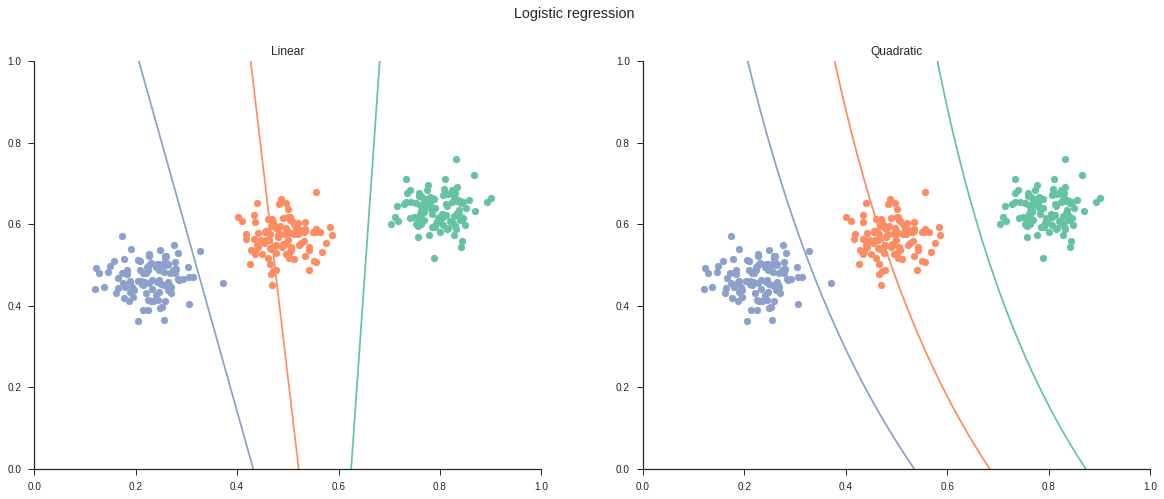

In [5]:
X, Y = generate_dataset(100, classes=3)
quad_X = np.hstack([X, (X[:, 0] * X[:, 1])[:, np.newaxis]])

fig = plt.figure(figsize=(20, 7.5))
fig.suptitle('Logistic regression')
    
beta = logistic_regression(X, Y)
plt.subplot(121)
plot_boundaries(X, Y, beta, False)
plt.title('Linear')

beta = logistic_regression(quad_X, Y)
plt.subplot(122)
plot_boundaries(X, Y, beta, True)
plt.title('Quadratic')

In [6]:
# generate a two class dataset
X, Y = generate_dataset(100, classes=2)

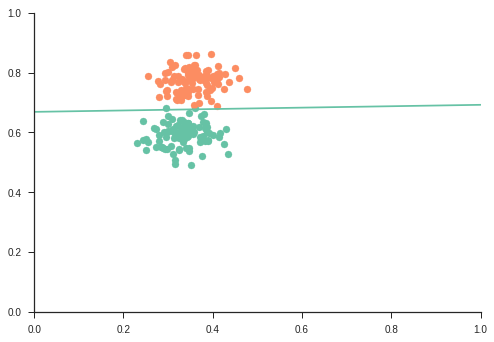

In [7]:
def perceptron(X, Y, epochs=50, alpha=0.001):
    """Perceptron training, yields the betas at each step"""
    X_pad = pad_design_matrix(X)
    # initialize beta
    beta = np.zeros(X.shape[1]+1)
    
    for i in range(epochs):
        clss = 1. * (X_pad.dot(beta) > 0) # convert to value
        beta += (alpha * (Y - clss)[:, np.newaxis] * X_pad).sum(axis=0)
        yield beta.copy()
        
        
beta = list(perceptron(X, Y, alpha=0.1, epochs=100))[-1]
plot_boundaries(X, Y, beta, False)

In [8]:
# animate perceptron training
def make_perceptron_animation(X, Y, alpha, epochs):
    fig, ax = plt.subplots()
    betas = list(perceptron(X, Y, alpha=alpha, epochs=epochs))
    for cls in set(Y):
        ax.scatter(X[Y == cls].T[0], X[Y == cls].T[1], axes=ax)

    # set the limits
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    sns.despine(fig=fig);

    # placeholder of diffrent color
    line, = ax.plot([1,2], [3, 4], 'C3')

    def update(i):
        # this basically receives the frame every time
        # and must modify the plot accordingly
        label = 'Epoch {0}'.format(i)
        ax.set_xlabel(label)

        beta = betas[i]
        X1 = np.linspace(0, 1, 1000)
        X2 = -(beta[1] * X1 + beta[0]) / beta[2]

        line.set_data(X1, X2);  # distinct color
        # also must return what changed
        return line, ax

    return FuncAnimation(fig, update, frames=np.arange(0, epochs), interval=150)
    
    
anim = make_perceptron_animation(X, Y, 0.01, 100)
plt.close()  # because jupyter hijacks matlpotlib and calls plt.show()
HTML(anim.to_html5_video())  # very useful for embedding